# Vehicle Detection Project

## The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector.
* Note: for those first two steps don’t forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

## 0. Import dependencys

In [1]:
from skimage.feature import hog
from sklearn.svm import *
from sklearn.grid_search import *
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import numpy as np
import pickle
import cv2
import glob
import time
import random

%matplotlib inline

/home/kulrich/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/kulrich/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


## 1. Trainingdata

In [2]:
output_dir = 'output_images/'
car_images = glob.glob('training_data/vehicles/**/*.png')
non_car_images = glob.glob('training_data/non-vehicles/**/*.png')
                       
num_of_cars = len(car_images);
num_of_non_cars = len(non_car_images)

print('Number of car images ' + str(num_of_cars))
print('Number of non car images ' + str(num_of_non_cars))

Number of car images 8792
Number of non car images 8968


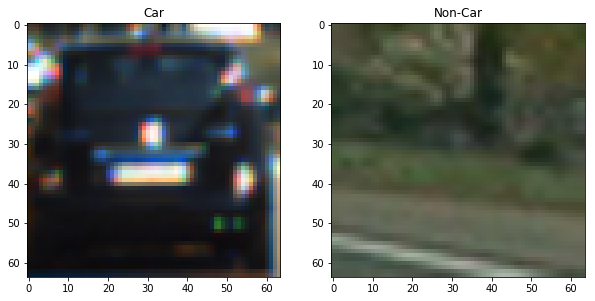

In [3]:
car_id = random.randint(1, num_of_cars) 
non_cars_id = random.randint(1, num_of_non_cars) 

car = plt.imread(car_images[car_id])
non_car = plt.imread(non_car_images[non_cars_id])

plt.figure(figsize=(10,40))
plt.subplot(1,2,1)
plt.imshow(car)
plt.title('Car')

plt.subplot(1,2,2)
plt.imshow(non_car)
plt.title('Non-Car')

plt.savefig(output_dir + 'training_data.png', bbox_inches='tight')

## 2. Feature extrection

### 1. Spatial color features 

In [4]:
def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))

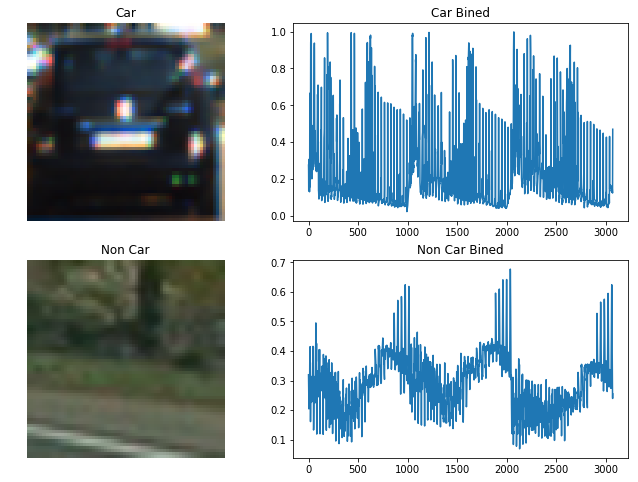

In [5]:
bined_car = bin_spatial(car)
bined_non_car = bin_spatial(non_car)

fig, axs = plt.subplots(2,2, figsize=(12,8))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()

axs[0].axis('off')
axs[0].set_title('Car')
axs[0].imshow(car)

axs[1].set_title('Car Bined')
axs[1].plot(bined_car)

axs[2].axis('off')
axs[2].set_title('Non Car')
axs[2].imshow(non_car)

axs[3].set_title('Non Car Bined')
axs[3].plot(bined_non_car)

plt.savefig(output_dir + 'bin_spatial.png', bbox_inches='tight')

### 2. Color histogram features  

In [6]:
def color_hist(img, nbins=32):    #bins_range=(0, 256)
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

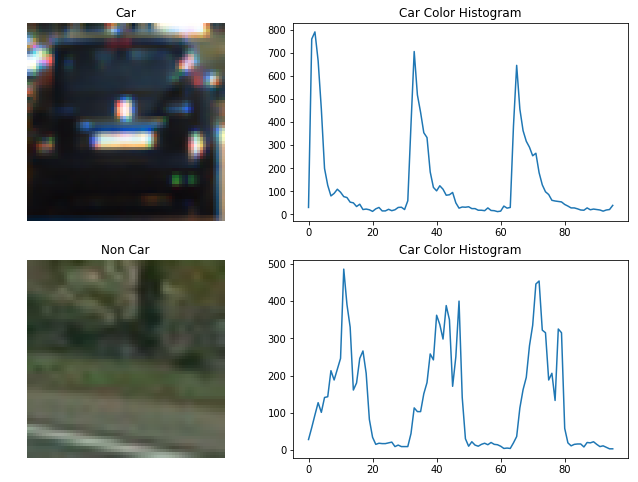

In [7]:
color_hist_car = color_hist(car)
color_hist_non_car = color_hist(non_car)

fig, axs = plt.subplots(2,2, figsize=(12,8))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()

axs[0].axis('off')
axs[0].set_title('Car')
axs[0].imshow(car)

axs[1].set_title('Car Color Histogram')
axs[1].plot(color_hist_car)

axs[2].axis('off')
axs[2].set_title('Non Car')
axs[2].imshow(non_car)

axs[3].set_title('Car Color Histogram')
axs[3].plot(color_hist_non_car)

plt.savefig(output_dir + 'color_hist.png', bbox_inches='tight')

### 3. HOG features

In [8]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                                  visualise=True, feature_vector=False)
        return features, hog_image
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                       visualise=False, feature_vector=feature_vec)
        return features

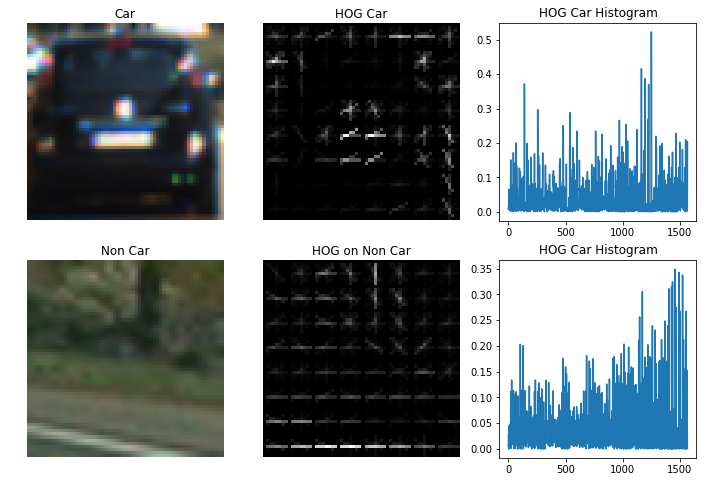

In [9]:
car_features, car_hog = get_hog_features(car[:,:,0], orient=8, pix_per_cell=8, cell_per_block=2, vis=True, feature_vec=True)
non_car_features, non_car_hog = get_hog_features(non_car[:,:,0], orient=8, pix_per_cell=8, cell_per_block=2, vis=True, feature_vec=True)

fig, axs = plt.subplots(2,3, figsize=(12,8))
axs = axs.ravel()

axs[0].axis('off')
axs[0].set_title('Car')
axs[0].imshow(car)

axs[1].axis('off')
axs[1].set_title('HOG Car')
axs[1].imshow(car_hog, cmap='gray')

axs[2].set_title('HOG Car Histogram')
axs[2].plot(np.ravel(car_features))

axs[3].axis('off')
axs[3].set_title('Non Car')
axs[3].imshow(non_car)

axs[4].axis('off')
axs[4].set_title('HOG on Non Car')
axs[4].imshow(non_car_hog, cmap='gray')

axs[5].set_title('HOG Car Histogram')
axs[5].plot(np.ravel(non_car_features))

plt.savefig(output_dir + 'features_HOG.png', bbox_inches='tight')

### 4. Extract Features

In [10]:
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

In [11]:
### TODO: Tweak these parameters and see how the results change.
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
#orient = 11
#pix_per_cell = 16
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [None, None] # Min and max in y to search in slide_window()

print('Start feature extraction ...' )
t=time.time()

car_features = extract_features(car_images, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

not_car_features = extract_features(non_car_images, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
t2=time.time()

print('Feature extraction needed ' + str(round(t2-t, 2)) + ' secs'  )

# Create an array stack of feature vectors
X = np.vstack((car_features, not_car_features)).astype(np.float64)  

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(not_car_features))))

Start feature extraction ...
Feature extraction needed 143.89 secs


In [12]:
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

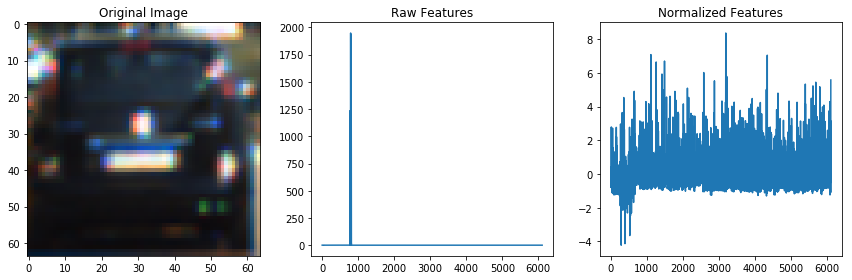

In [13]:
# Plot an example of raw and scaled features
fig = plt.figure(figsize=(12,4))
plt.subplot(131)
plt.imshow(mpimg.imread(car_images[car_id]))
plt.title('Original Image')
plt.subplot(132)
plt.plot(X[car_id])
plt.title('Raw Features')
plt.subplot(133)
plt.plot(scaled_X[car_id])
plt.title('Normalized Features')
fig.tight_layout()
plt.savefig(output_dir + 'features_extraction.png', bbox_inches='tight')

## 3. Training

### 1. Split Traindata  into Train and Testsdata

In [14]:
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split( scaled_X, y, test_size=0.2, random_state=rand_state )

print('Feature vector length:', len(X_train[0]))

Feature vector length: 6108


### 2. Training a SVC

In [15]:
TRAINING = 'LINEAR' # LINEAR, GRID_SEARCH_CV, RANDOM_SEARCH_CV

print('Start training')
t=time.time()  

if TRAINING  == 'GRID_SEARCH_CV':
    parameters = {'kernel':('linear', 'rbf'), 'C':[1, 5]}
    c = SVC()
    svc = GridSearchCV(c, parameters, verbose=10, n_jobs=3)
    svc.fit(X_train, y_train)
    print(svc.best_params_)

if TRAINING == 'RANDOM_SEARCH_CV': 
    parameters = {'kernel':('linear', 'rbf'), 'C':[1, 5]}
    c = SVC()
    svc = RandomizedSearchCV(c, parameters, 3, verbose=10, n_jobs=3)
    svc.fit(X_train, y_train)
    print(svc.best_params_)
    
if TRAINING == 'LINEAR': 
    # Use a linear SVC 
    svc = LinearSVC()
    svc.fit(X_train, y_train)
    
    

t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')

Start training
12.31 Seconds to train SVC...


### 3. Accuracy and predictions

In [16]:
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

Test Accuracy of SVC =  0.9907
My SVC predicts:  [ 1.  1.  0.  1.  0.  0.  1.  0.  1.  0.]
For these 10 labels:  [ 1.  1.  0.  1.  0.  0.  1.  0.  1.  0.]
0.00502 Seconds to predict 10 labels with SVC


In [17]:
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

In [18]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, show_all_rectangles=False):
    # array of rectangles where cars were detected
    rectangles = []
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    # select colorspace channel for HOG 
    if hog_channel == 'ALL':
        ch1 = ctrans_tosearch[:,:,0]
        ch2 = ctrans_tosearch[:,:,1]
        ch3 = ctrans_tosearch[:,:,2]
    else: 
        ch1 = ctrans_tosearch[:,:,hog_channel]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)   
    if hog_channel == 'ALL':
        hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            if hog_channel == 'ALL':
                hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            else:
                hog_features = hog_feat1

            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1 or show_all_rectangles:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                rectangles.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                
    return rectangles

In [19]:
test_img = mpimg.imread('./test_images/test1.jpg')

ystart = 400
ystop = 656
scale = 1.5

rectangles = find_cars(test_img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

print(len(rectangles), 'rectangles found in image')

12 rectangles found in image


In [20]:
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    random_color = False
    # Iterate through the bounding boxes
    for bbox in bboxes:
        if color == 'random' or random_color:
            color = (np.random.randint(0,255), np.random.randint(0,255), np.random.randint(0,255))
            random_color = True
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy


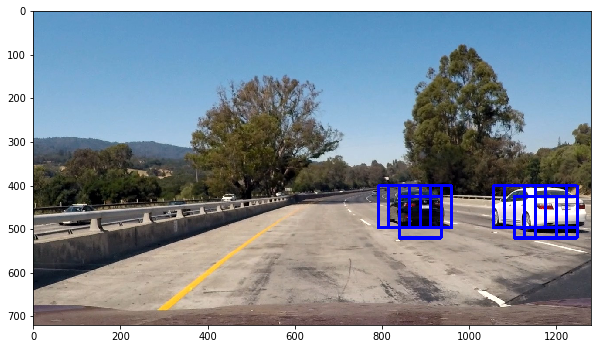

In [21]:
test_img_rects = draw_boxes(test_img, rectangles)
plt.figure(figsize=(10,10))
plt.imshow(test_img_rects)
plt.savefig(output_dir + 'draw_boxes.png', bbox_inches='tight')

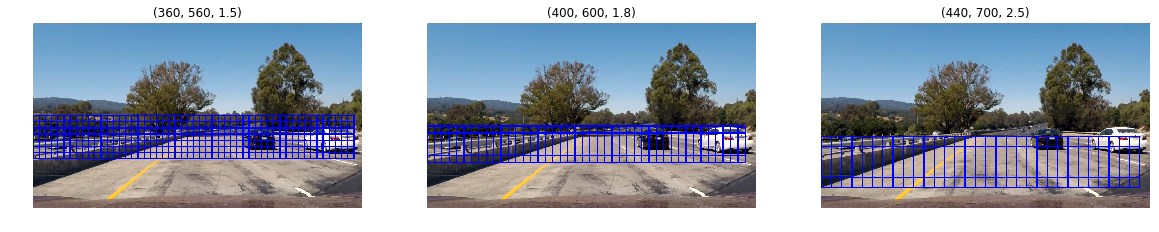

In [22]:
test_img = mpimg.imread('./test_images/test1.jpg')
'''
search_area = [
    #(380, 480, 1.0),
    (400, 464, 1.0),
    #(416, 480, 1.0),
    #(400, 600, 1.5),
    #(400, 496, 1.5),
    (432, 528, 1.5),
    (400, 528, 2.0),
    #(432, 560, 2.0),
    (500, 700, 2.5),
    #(400, 596, 3.5),
    #(464, 660, 3.5)
    ]

search_area = [(380, 480, 1), (400, 600, 1.5), (500, 700, 2.5)]
'''
search_area = [(360, 560, 1.5), (400, 600, 1.8), (440, 700, 2.5)]

rects = []

for (ystart, ystop, scale) in search_area:
    rects.append(find_cars(test_img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, show_all_rectangles=True))


cols = 3
rows = 1
fig, axs = plt.subplots(rows, cols, figsize=(20,10))
axs = axs.ravel()

i = 0
for sublist in rects:
    test_img_rects = draw_boxes(test_img, sublist, thick=3)
    axs[i].axis('off')
    axs[i].set_title(str(search_area[i]))
    axs[i].imshow(test_img_rects)
    i = i + 1
    
if i < cols * rows:
    axs[i].axis('off')
    i = i + 1   
    
plt.savefig(output_dir + 'search_area.png', bbox_inches='tight')    

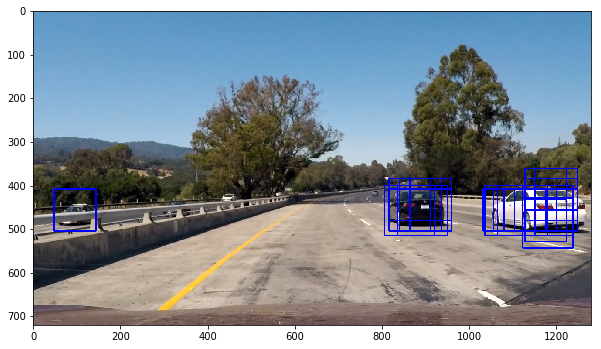

In [23]:
rects = []

for (ystart, ystop, scale) in search_area:
    rects.append(find_cars(test_img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, show_all_rectangles=False))

rectangles = [item for sublist in rects for item in sublist] 
test_img_rects = draw_boxes(test_img, rectangles, thick=2)
plt.figure(figsize=(10,10))
plt.imshow(test_img_rects)

plt.savefig(output_dir + 'image_labeled.png', bbox_inches='tight')    

### Heatmap

In [24]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

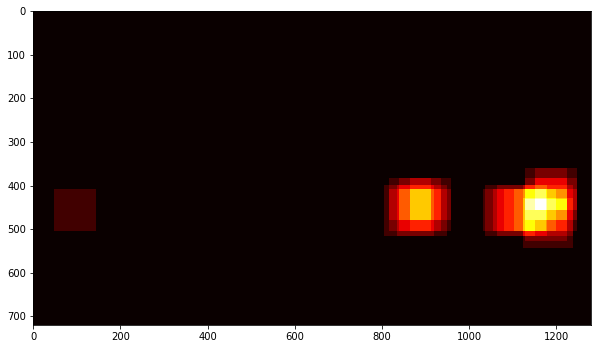

In [25]:
heatmap_img = np.zeros_like(test_img[:,:,0])
heatmap_img = add_heat(heatmap_img, rectangles)
plt.figure(figsize=(10,10))
plt.imshow(heatmap_img, cmap='hot')
plt.savefig(output_dir + 'heatmap.png', bbox_inches='tight')    

In [26]:
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

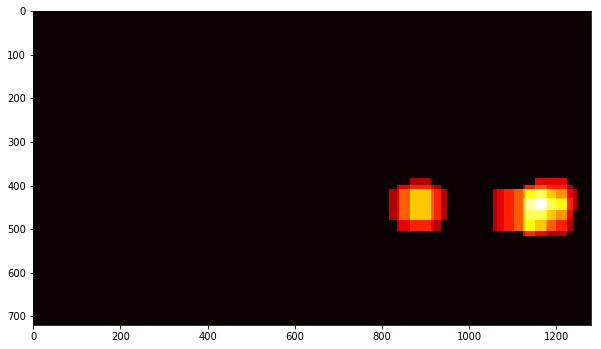

In [27]:
threshold = 2
heatmap_img = apply_threshold(heatmap_img, threshold)
plt.figure(figsize=(10,10))
plt.imshow(heatmap_img, cmap='hot')
plt.savefig(output_dir + 'heatmap_threshold.png', bbox_inches='tight')    

2 cars found


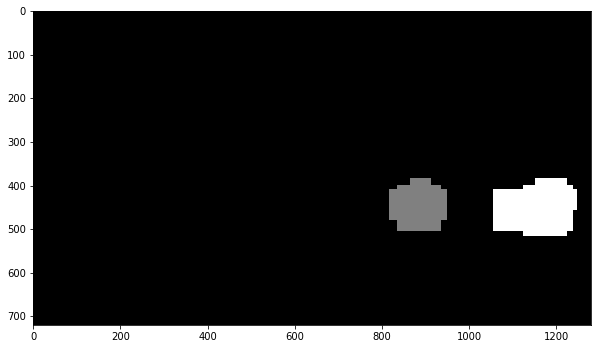

In [28]:
labels = label(heatmap_img)
plt.figure(figsize=(10,10))
plt.imshow(labels[0], cmap='gray')
plt.savefig(output_dir + 'labeled.png', bbox_inches='tight')    
print(labels[1], 'cars found')

In [29]:
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    rects = []
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        rects.append(bbox)
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image and final rectangles
    return img, rects

In [30]:
def process(test_img):
    loca_rects = []
    for (ystart, ystop, scale) in search_area:
        loca_rects.append(find_cars(test_img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, show_all_rectangles=False))

    rectangles = [item for sublist in loca_rects for item in sublist] 
       
    h_img = np.zeros_like(test_img[:,:,0])
    h_img = add_heat(h_img, rectangles)
     
    thred_heatmap_img = apply_threshold(h_img, threshold)
        
    labels = label(thred_heatmap_img)
        
    draw_img, rects = draw_labeled_bboxes(test_img, labels)
    return draw_img

0.85 Seconds to prozess image


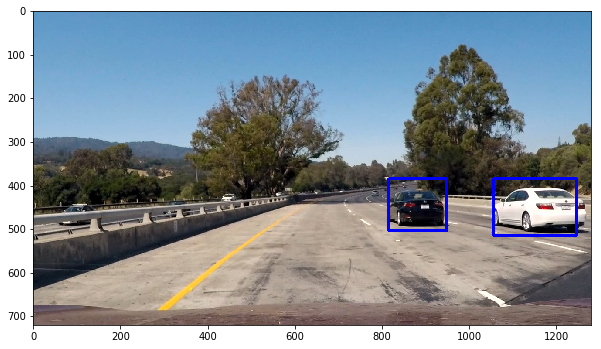

In [31]:
# Draw bounding boxes on a copy of the image
t=time.time()  
draw_img = process(test_img)
t2=time.time()
print(round(t2-t, 2), 'Seconds to prozess image')
# Display the image
plt.figure(figsize=(10,10))
plt.imshow(draw_img)
plt.savefig(output_dir + 'result.png', bbox_inches='tight')    


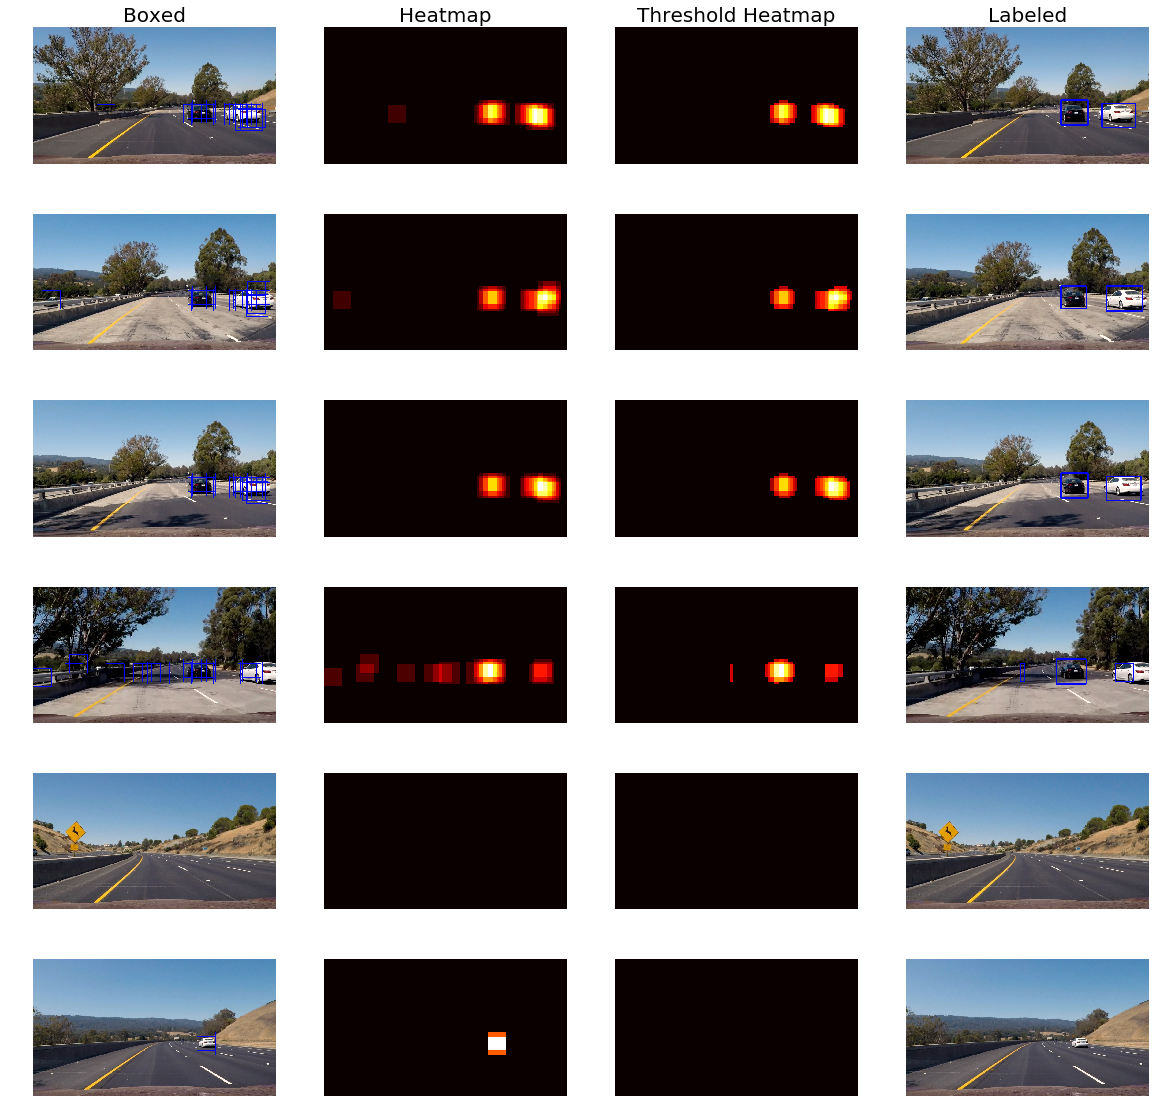

In [32]:
images = glob.glob('./test_images/*.jpg')
i = 0
COLUMNS_HEADER = ['Boxed', 'Heatmap', 'Threshold Heatmap', 'Labeled']
f, axs = plt.subplots(len(images), len(COLUMNS_HEADER), figsize=(20,20))
axs = axs.ravel()

for image in images:
    rects = []
    
    test_img = mpimg.imread(image)

    for (ystart, ystop, scale) in search_area:
        rects.append(find_cars(test_img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, show_all_rectangles=False))

    rectangles = [item for sublist in rects for item in sublist] 
    test_img_rects = draw_boxes(test_img, rectangles, thick=2)
        
    h_img = np.zeros_like(test_img[:,:,0])
    h_img = add_heat(h_img, rectangles)
    heatmap_img = np.copy(h_img) 
     
    thred_heatmap_img = apply_threshold(h_img, threshold)
        
    labels_img = label(thred_heatmap_img)
        
    draw_img = process(test_img)
        
        
    if(i < len(COLUMNS_HEADER)):
        axs[i].set_title(COLUMNS_HEADER[i % len(COLUMNS_HEADER)], fontsize=20)
    axs[i].imshow(test_img_rects)
    axs[i].axis('off')
    i += 1
    
    if(i < len(COLUMNS_HEADER)):
        axs[i].set_title(COLUMNS_HEADER[i % len(COLUMNS_HEADER)], fontsize=20)
    axs[i].imshow(heatmap_img, cmap='hot')
    axs[i].axis('off')
    i += 1
            
    if(i < len(COLUMNS_HEADER)):
        axs[i].set_title(COLUMNS_HEADER[i % len(COLUMNS_HEADER)], fontsize=20)
    axs[i].imshow(thred_heatmap_img, cmap='hot')
    axs[i].axis('off')
    i += 1
    
    if(i < len(COLUMNS_HEADER)):
        axs[i].set_title(COLUMNS_HEADER[i % len(COLUMNS_HEADER)], fontsize=20)
    axs[i].imshow(draw_img)
    axs[i].axis('off')
    i += 1
                
plt.savefig(output_dir + 'pipline.png', bbox_inches='tight')          

In [33]:
test_out_file = 'test_video_out.mp4'
clip_test = VideoFileClip('test_video.mp4')
clip_test_out = clip_test.fl_image(process)
%time clip_test_out.write_videofile(test_out_file, audio=False)

[MoviePy] >>>> Building video test_video_out.mp4
[MoviePy] Writing video test_video_out.mp4


 97%|█████████▋| 38/39 [00:31<00:00,  1.15it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_out.mp4 

CPU times: user 36.3 s, sys: 124 ms, total: 36.4 s
Wall time: 33.2 s


In [34]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(test_out_file))

In [35]:
out_file = 'project_video_out.mp4'
clip = VideoFileClip('project_video.mp4')
clip_out = clip.fl_image(process)
%time clip_out.write_videofile(out_file, audio=False)

[MoviePy] >>>> Building video project_video_out.mp4
[MoviePy] Writing video project_video_out.mp4


100%|█████████▉| 1260/1261 [18:05<00:00,  1.21it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_out.mp4 

CPU times: user 20min 37s, sys: 3.9 s, total: 20min 41s
Wall time: 18min 7s


In [36]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(out_file))